In [1]:
!git clone https://github.com/Siahkamari/Piecewise-linear-regression.git
%cd /content/Piecewise-linear-regression/Python

fatal: destination path 'Piecewise-linear-regression' already exists and is not an empty directory.
/content/Piecewise-linear-regression/Python


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read the data in numpy format (.npy)

In [3]:
col_names = ['Frequency','Angle of attack','Chord length','Velocity','Thickness','Sound pressure']
df = pd.read_csv('airfoil_self_noise.csv',delimiter='\t',names=col_names)
df.head()

,Frequency,Angle of attack,Chord length,Velocity,Thickness,Sound pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Split the data to training and test

In [4]:
features = ["Frequency","Chord length"]
df = df.groupby(features).mean().reset_index()
y = df["Sound pressure"].to_numpy()
X = df[features].to_numpy()
n = len(y)

rng = np.random.default_rng(0)
I= rng.permutation(n)
X = X[I]
y = y[I]

mu = np.mean(X,axis=0)
X = (X-mu)/np.max(np.abs(X),axis=0)
y = y/np.max(np.abs(y))

X_train = X[0:int(4/5*n)]
y_train = y[0:int(4/5*n)]

X_test = X[int(4/5*n):]
y_test = y[int(4/5*n):]

## DC regression

In [5]:
import torch as th
from piecewise_linear_estimation import dc_regression
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

X_train_th = th.from_numpy(X_train.astype('float64')).to(device)
y_train_th = th.from_numpy(y_train.astype('float64')).to(device)
X_test_th = th.from_numpy(X_test.astype('float64')).to(device)
y_test_th = th.from_numpy(y_test.astype('float64')).to(device)

model = dc_regression()
# Fitting
model.fit(X_train_th, y_train_th, lanbda=0.001, n_iter=2000)

# Testing
train_loss = model.score(X_train_th, y_train_th).item()
test_loss = model.score(X_test_th, y_test_th).item()
print("\n~~~~~~~~~~~~~~~~~~~~~~~~")
print("Train R^2 = ", round(train_loss,2))
print("Test R^2 = ", round(test_loss,2))



~~~~~~~~~~~~~~~~~~~~~~~~
Train R^2 =  0.98
Test R^2 =  0.97


## Surf plot of estimators in 2 dimmensions

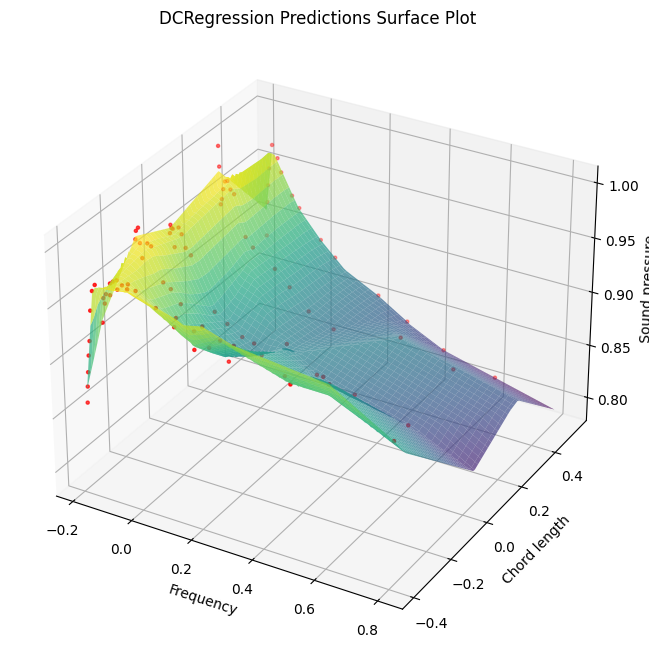

In [6]:
# Create a grid of values
x1 = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
x2 = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)

# Flatten the grid to pass through the model
X_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# Predict using the trained XGBoost model
X_grid_th = th.from_numpy(X_grid.astype('float64')).to(device)
y_pred = model.predict(X_grid_th).cpu().detach().numpy()

# Reshape predictions back into grid shape
y_pred_grid = y_pred.reshape(x1_grid.shape)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid, x2_grid, y_pred_grid, cmap='viridis', alpha=0.7)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='red', marker='.')

# Set labels
ax.set_xlabel('Frequency')
ax.set_ylabel('Chord length')
ax.set_zlabel('Sound pressure')
ax.set_title('DCRegression Predictions Surface Plot')

plt.show()